In [1]:
# Read the meta data using pandas
import pandas as pd

data_dir = "./data/brain/"

meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
meta_data.head() # show the first five data entries

,ID,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

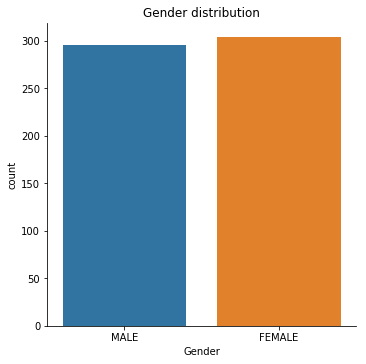

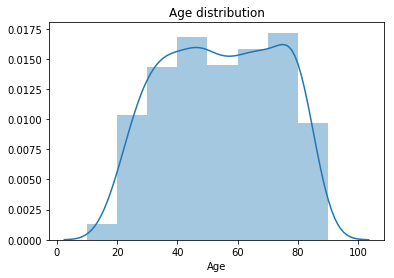

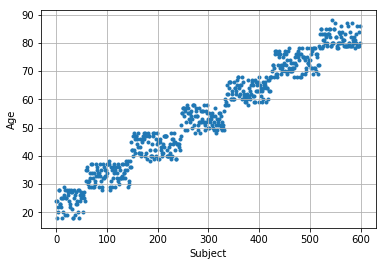

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

from image_viewer import display_image

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


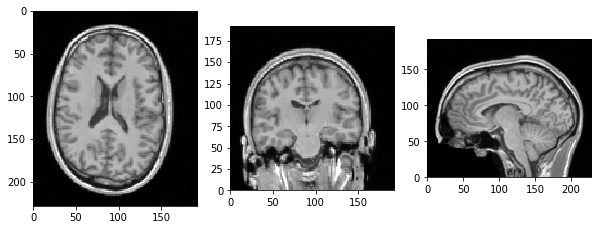

Brain mask (used in part A)


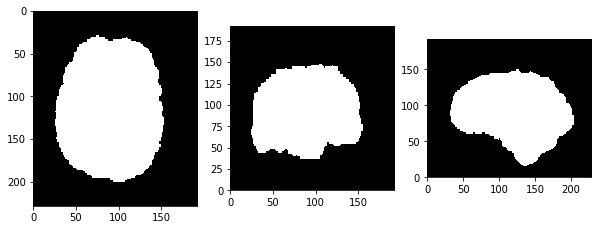

Spatially normalised grey matter maps (used in part B)


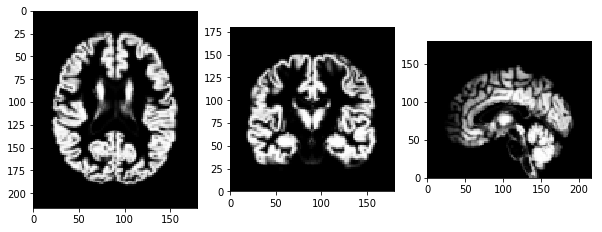

In [5]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]

# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


image_filename = [f for f in image_filenames if ID in f][0]
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)

#### Imports

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from data_helper import ImageSegmentationDataset

#### Check that the GPU is up and running

In [8]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: GeForce GTX 1080


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [9]:
rnd_seed = 42 #fixed random seed

#Highest possible definition (original image definition)
img_size = [128, 152, 128]
img_spacing = [1.5, 1.5, 1.5]

num_epochs = 30
learning_rate = 0.001
batch_size = 1 #Max batch size in order to fit in memory: Unet is quite large in memory
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**We provide a 'debug' csv file pointing to just a few images for training. Replace this with the full training dataset when you train your full model.**

In [10]:
# USE THIS FOR TRAINING ON ALL 47 SUBJECTS
train_data = data_dir + 'train/csv/train.csv'

# USE THIS FOR DEBUGGING WITH JUST 2 SUBJECTS
# train_data = data_dir + 'train/csv/train_debug.csv'

val_data = data_dir + 'train/csv/val.csv'

print('LOADING TRAINING DATA...')
dataset_train = ImageSegmentationDataset(train_data, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

print('\nLOADING VALIDATION DATA...')
dataset_val = ImageSegmentationDataset(val_data, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

LOADING TRAINING DATA...
+ reading image msub-CC110319_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110319.nii.gz
+ reading mask sub-CC110319_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC120208_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC120208.nii.gz
+ reading mask sub-CC120208_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC120462_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC120462.nii.gz
+ reading mask sub-CC120462_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC121144_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC121144.nii.gz
+ reading mask sub-CC121144_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC122405_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC122405.nii.gz
+ reading mask sub-CC122405_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC210422_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC210422.nii.gz
+ reading mask sub-CC210422_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC220203_T1w_rigid

#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: msub-CC110319_T1w_rigid_to_mni.nii.gz


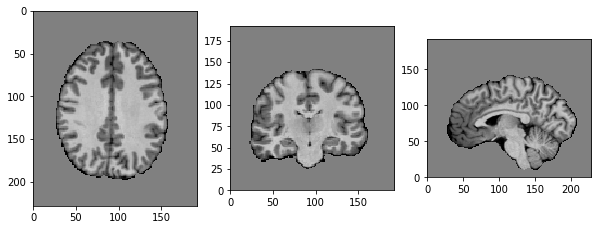

Segmentation: CC110319.nii.gz


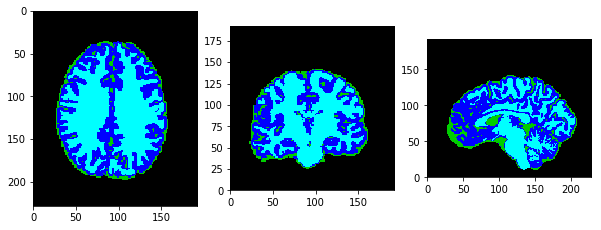

Mask


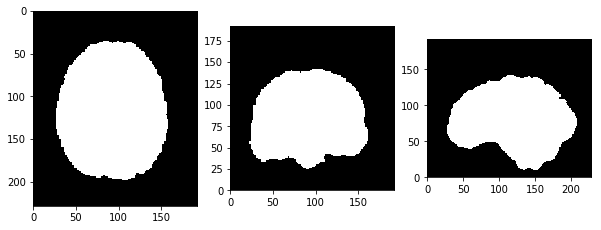

In [11]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation: ' + seg_name)
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [12]:
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(32, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)

In [13]:
class LeNet3D(nn.Module):

    def __init__(self, num_classes):
        super(LeNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(6, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 120, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(120, 84, kernel_size=1)
        self.conv5 = nn.Conv3d(84, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return F.softmax(x, dim=1)

In [14]:
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    #Perform a block of the Unet
    return [
        nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)]

class UNet3D(nn.Module):
    #Unet presented in lecture but smaller
    def __init__(self, num_classes):
        super(UNet3D, self).__init__()
        #Downsampling part
        self.down1 = nn.Sequential(
            *make_conv_bn_relu(1, 32, kernel_size=3, stride=1, padding=1 ),
            *make_conv_bn_relu(32, 32, kernel_size=3, stride=1, padding=1 ))
        
        self.down2 = nn.Sequential(
            *make_conv_bn_relu(32, 64, kernel_size=3, stride=1, padding=1 ),
            *make_conv_bn_relu(64, 64, kernel_size=3, stride=1, padding=1 ))
        
        self.bottom = nn.Sequential(
            *make_conv_bn_relu(64, 128, kernel_size=3, stride=1, padding=1 ),
            *make_conv_bn_relu(128, 128, kernel_size=3, stride=1, padding=1 ))
        
        #Upsampling part
        self.upsample1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        
        self.up1 = nn.Sequential(
            *make_conv_bn_relu(128, 64, kernel_size=3, stride=1, padding=1 ),
            *make_conv_bn_relu(64, 64, kernel_size=3, stride=1, padding=1 ))

        self.upsample2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        
        self.up2 = nn.Sequential(
            *make_conv_bn_relu(64, 32, kernel_size=3, stride=1, padding=1 ),
            *make_conv_bn_relu(32, 32, kernel_size=3, stride=1, padding=1 ))
        
        
        self.final_conv = nn.Conv3d(32, num_classes, kernel_size=1)
        
    def forward(self, x):
        first_down = self.down1(x) #64*64
        first_out = F.max_pool3d(first_down, kernel_size=2, stride=2)
        
        second_down = self.down2(first_out) #32*32
        second_out = F.max_pool3d(second_down, kernel_size=2, stride=2)
        
        bottom = self.bottom(second_out) # 16*16
        
        first_up = self.upsample1(bottom) #32*32
        first_up = torch.cat([second_down, first_up], 1)#skip connections
        first_up = self.up1(first_up)

        second_up = self.upsample2(first_up) #64*64
        second_up = torch.cat([first_down, second_up], 1)#skip connections
        second_up = self.up2(second_up)
        
        x = self.final_conv(second_up)
        return F.softmax(x, dim=1)


My architecture is an U-Net adapted for 32*32*3 images based on the paper https://arxiv.org/abs/1505.04597

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

In [15]:
def evaluate_metrics(prediction, gold_standard):
    """
    Compute and average some metrics for of the 4 segmentations classes
    """
    accuracy = 0
    recall = 0
    dice_score = 0 
    prediction = torch.argmax(prediction, dim=1)
    prediction = prediction[0]
    gold_standard = gold_standard[0][0]
    for i in range(4):
        TP= float((prediction[gold_standard==i] == i).sum())
        FP = float((prediction[gold_standard!=i] == i).sum())
        TN = float(len(prediction[gold_standard!=i]) - FP )
        FN = float(len(prediction[gold_standard==i]) - TP)
        accuracy += (TP + TN)/(TP + FN + TN + FP)
        recall += TP / (TP + FN)
        dice_score += 2*TP / (2*TP+FP+FN)
    return accuracy/4, recall/4, dice_score/4

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.215635
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 1.219756


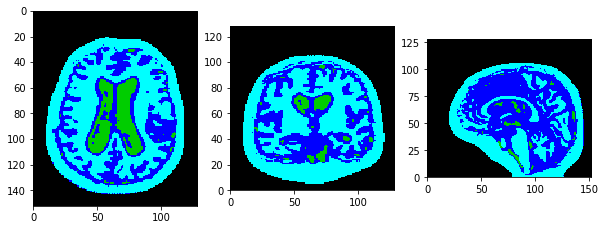

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 1.026881
+ TRAINING 	Epoch: 3 	Loss: 0.875002
+ TRAINING 	Epoch: 4 	Loss: 0.805281
+ TRAINING 	Epoch: 5 	Loss: 0.781606
+ TRAINING 	Epoch: 6 	Loss: 0.768757
+ TRAINING 	Epoch: 7 	Loss: 0.766274
+ TRAINING 	Epoch: 8 	Loss: 0.761625
+ TRAINING 	Epoch: 9 	Loss: 0.759130
+ TRAINING 	Epoch: 10 	Loss: 0.758819
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.759171


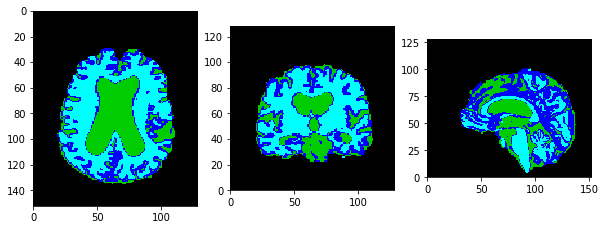

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.754410
+ TRAINING 	Epoch: 12 	Loss: 0.757050
+ TRAINING 	Epoch: 13 	Loss: 0.753254
+ TRAINING 	Epoch: 14 	Loss: 0.753127
+ TRAINING 	Epoch: 15 	Loss: 0.752637
+ TRAINING 	Epoch: 16 	Loss: 0.751523
+ TRAINING 	Epoch: 17 	Loss: 0.753209
+ TRAINING 	Epoch: 18 	Loss: 0.754919
+ TRAINING 	Epoch: 19 	Loss: 0.749320
+ TRAINING 	Epoch: 20 	Loss: 0.752874
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.753533


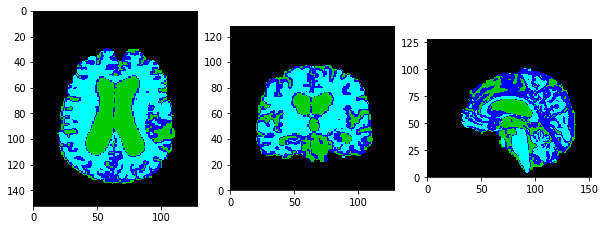

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.750473
+ TRAINING 	Epoch: 22 	Loss: 0.750360
+ TRAINING 	Epoch: 23 	Loss: 0.748271
+ TRAINING 	Epoch: 24 	Loss: 0.750446
+ TRAINING 	Epoch: 25 	Loss: 0.750219
+ TRAINING 	Epoch: 26 	Loss: 0.750194
+ TRAINING 	Epoch: 27 	Loss: 0.749523
+ TRAINING 	Epoch: 28 	Loss: 0.748635
+ TRAINING 	Epoch: 29 	Loss: 0.749910
+ TRAINING 	Epoch: 30 	Loss: 0.750042
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.750109


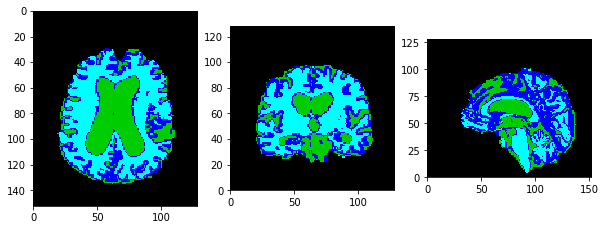

--------------------------------------------------

Finished TRAINING.


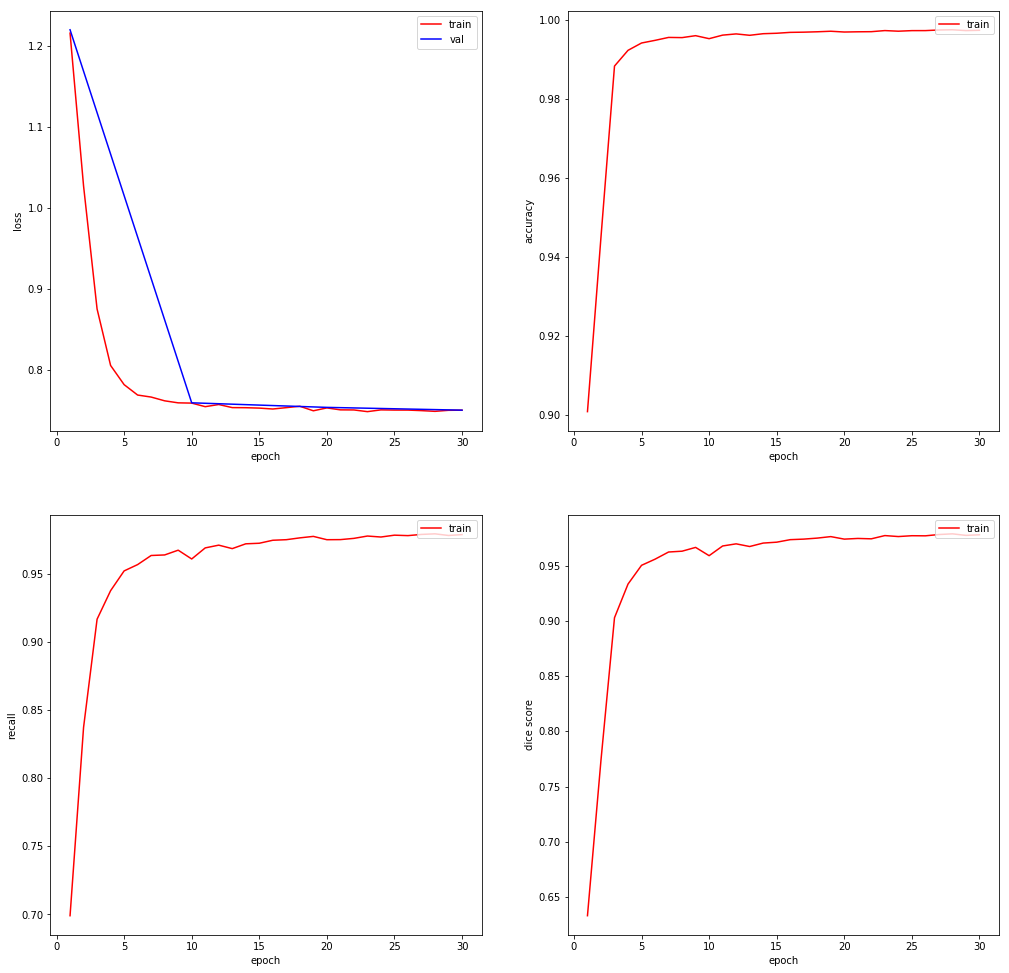

In [16]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

#model = SimpleNet3D(num_classes=num_classes).to(device)
#model = LeNet3D(num_classes=num_classes).to(device)
model = UNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dsc_train_log = []
accuracy_train_log = []
recall_train_log = []
dsc_val_log = []
accuracy_val_log = []
recall_val_log = []

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):
    
    dsc_score = 0
    accuracy = 0
    recall = 0
    
    
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()
        
        #monitor precision, recall and Dice scores
        metrics = evaluate_metrics(prd_flat, seg_flat)
        dsc_score += metrics[2]
        accuracy += metrics[0]
        recall += metrics[1]
        
    dsc_train_log.append(dsc_score/len(dataloader_train))
    accuracy_train_log.append(accuracy/len(dataloader_train))
    recall_train_log.append(recall/len(dataloader_train))
    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))




Finished TRAINING.


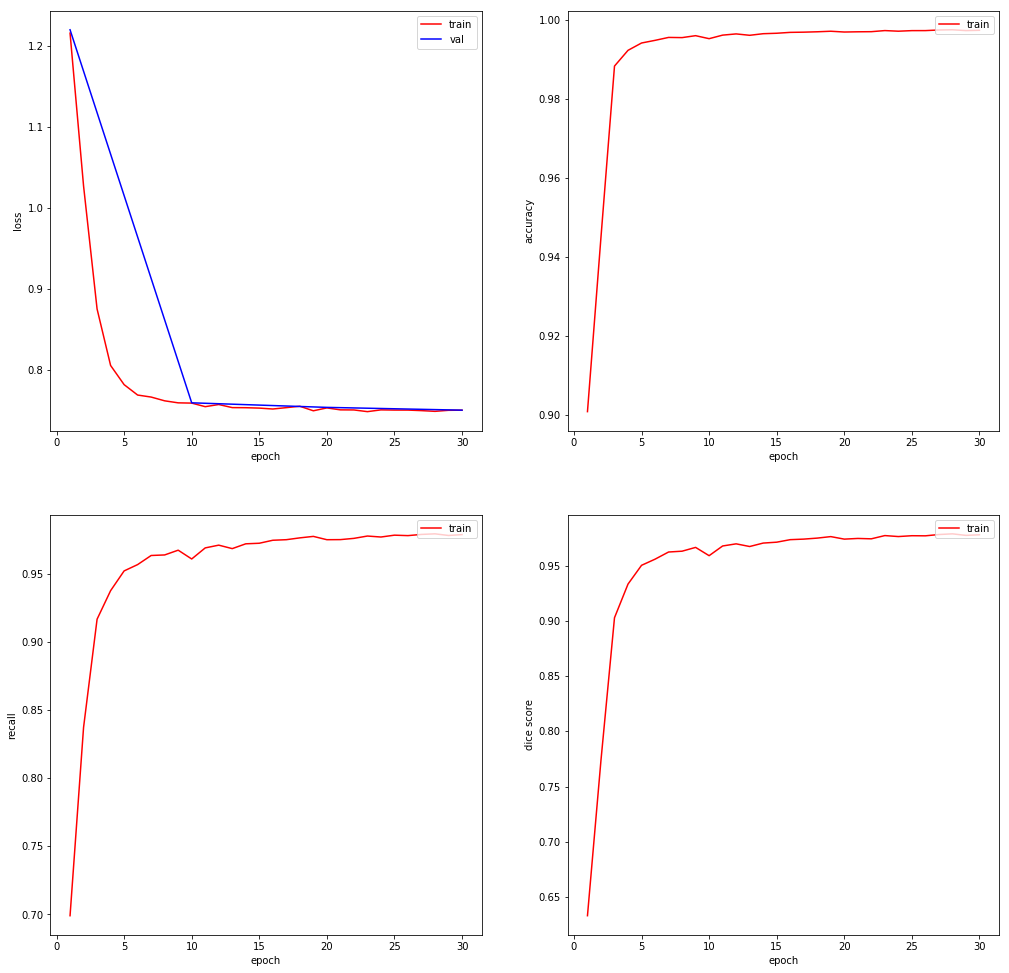

In [37]:
### Display training logs such as loss, accuracy, dice score, recall

print('\nFinished TRAINING.')
fig = plt.figure(figsize=(17,17))

plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_train_log, c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), recall_train_log, c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('recall')

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), dsc_train_log, c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('dice score')
plt.show()

The above plots are metrics over the epochs averaged between the 4 segmentation classes.

We can see that the model is still improving at between the 25th and 30th epoch. It could be worth to do more epochs but since
it is very computationally expensive we decided to stop at 30. 

We don't observe any overfitting since the validation loss is also decreasing in the last epoch. Thus regularization does not seem to be needed here.

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to our test dataset. Before testing on the full 600 subjects, you may want to initially just test on the 5 validation subjects.

In [17]:
# USE THIS FOR TESTING ON THE 600 SUBJECTS
test_data = data_dir + 'csv/test.csv'

# USE THIS FOR TESTING ON THE 5 VALIDATION SUBJECTS
#test_data = data_dir + 'train/csv/val.csv'

print('LOADING TESTING DATA...')
dataset_test = ImageSegmentationDataset(test_data, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

LOADING TESTING DATA...
+ reading image msub-CC110033_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110033.nii.gz
+ reading mask sub-CC110033_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110037_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110037.nii.gz
+ reading mask sub-CC110037_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110045_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110045.nii.gz
+ reading mask sub-CC110045_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110056_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110056.nii.gz
+ reading mask sub-CC110056_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110062_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110062.nii.gz
+ reading mask sub-CC110062_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110069_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110069.nii.gz
+ reading mask sub-CC110069_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110087_T1w_rigid_

+ reading mask sub-CC221002_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221031_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221031.nii.gz
+ reading mask sub-CC221031_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221033_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221033.nii.gz
+ reading mask sub-CC221033_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221038_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221038.nii.gz
+ reading mask sub-CC221038_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221040_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221040.nii.gz
+ reading mask sub-CC221040_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221054_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221054.nii.gz
+ reading mask sub-CC221054_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221107_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221107.nii.gz
+ reading mask sub-CC221107_T1w_rigid_to_mni_brain_mask.nii.gz
+

+ reading segmentation CC320686.nii.gz
+ reading mask sub-CC320686_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320687_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320687.nii.gz
+ reading mask sub-CC320687_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320759_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320759.nii.gz
+ reading mask sub-CC320759_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320776_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320776.nii.gz
+ reading mask sub-CC320776_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320814_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320814.nii.gz
+ reading mask sub-CC320814_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320850_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320850.nii.gz
+ reading mask sub-CC320850_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320870_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320870.nii.gz
+ reading mask sub-CC3208

+ reading image msub-CC420383_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420383.nii.gz
+ reading mask sub-CC420383_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420392_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420392.nii.gz
+ reading mask sub-CC420392_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420396_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420396.nii.gz
+ reading mask sub-CC420396_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420402_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420402.nii.gz
+ reading mask sub-CC420402_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420412_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420412.nii.gz
+ reading mask sub-CC420412_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420433_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420433.nii.gz
+ reading mask sub-CC420433_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420435_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading mask sub-CC520673_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC520745_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC520745.nii.gz
+ reading mask sub-CC520745_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC520868_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC520868.nii.gz
+ reading mask sub-CC520868_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC520980_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC520980.nii.gz
+ reading mask sub-CC520980_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC521040_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC521040.nii.gz
+ reading mask sub-CC521040_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610022_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610022.nii.gz
+ reading mask sub-CC610022_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610028_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610028.nii.gz
+ reading mask sub-CC610028_T1w_rigid_to_mni_brain_mask.nii.gz
+

+ reading segmentation CC710154.nii.gz
+ reading mask sub-CC710154_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710176_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710176.nii.gz
+ reading mask sub-CC710176_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710214_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710214.nii.gz
+ reading mask sub-CC710214_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710313_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710313.nii.gz
+ reading mask sub-CC710313_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710342_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710342.nii.gz
+ reading mask sub-CC710342_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710350_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710350.nii.gz
+ reading mask sub-CC710350_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710382_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710382.nii.gz
+ reading mask sub-CC7103

#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: msub-CC110033_T1w_rigid_to_mni.nii.gz


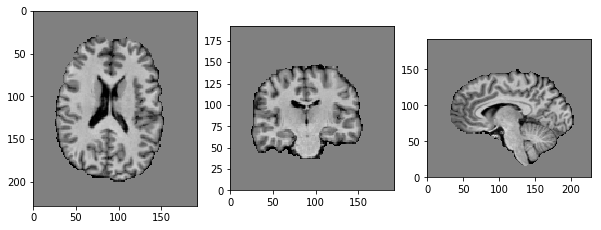

Segmentation: CC110033.nii.gz


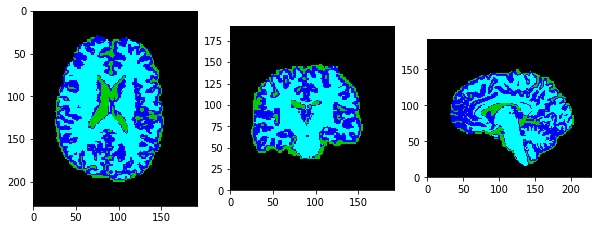

Mask


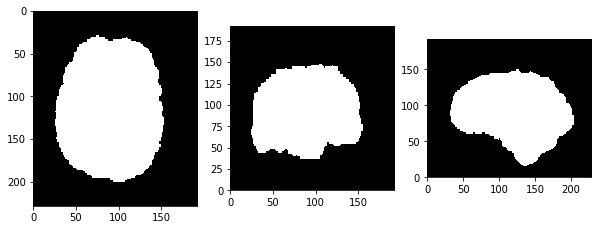

In [18]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation: ' + seg_name)
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

In [19]:
def evaluate(prediction, gold_standard):
    """
    Compute and average some metrics for of the 4 segmentations classes
    """
    accuracy = torch.zeros(4)
    recall = torch.zeros(4)
    dice_score = torch.zeros(4)
    prediction = torch.argmax(prediction, dim=1)
    prediction = prediction[0]
    gold_standard = gold_standard[0][0]
    for i in range(4):
        TP= float((prediction[gold_standard==i] == i).sum())
        FP = float((prediction[gold_standard!=i] == i).sum())
        TN = float(len(prediction[gold_standard!=i]) - FP )
        FN = float(len(prediction[gold_standard==i]) - TP)
        accuracy[i] = (TP + TN)/(TP + FN + TN + FP)
        recall[i] = TP / (TP + FN)
        dice_score[i] = 2*TP / (2*TP+FP+FN)
    return accuracy, recall, dice_score

START TESTING...
+ TESTING 	Loss: 0.750655


Reference segmentation


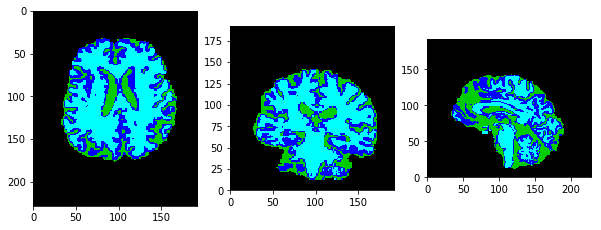

Predicted segmentation


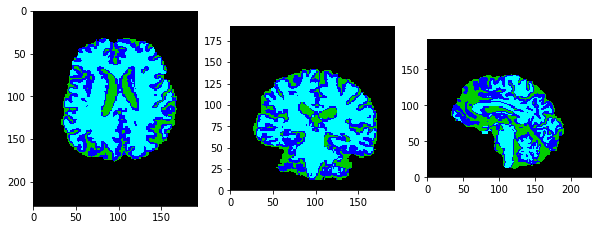

PER TISSU METRICS:
Overall Dice score: tensor([0.9998, 0.9552, 0.9539, 0.9779])
Overall Accuracy: tensor([0.9996, 0.9973, 0.9938, 0.9968])
Overall Recall tensor([0.9998, 0.9372, 0.9802, 0.9645])

Finished TESTING.


In [20]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

#model = SimpleNet3D(num_classes=num_classes)
model = UNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
global_acc = torch.zeros(4)
global_recall = torch.zeros(4)
global_dice = torch.zeros(4)
all_dice = []
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        metrics = evaluate(prd_flat, seg_flat)
        global_acc = torch.add(metrics[0], global_acc)
        global_recall = torch.add(metrics[1], global_recall)
        global_dice = torch.add(metrics[2], global_dice)
        all_dice.append(metrics[2])
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
global_acc/= len(dataloader_test)
global_recall /= len(dataloader_test)
global_dice /= len(dataloader_test)

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print("PER TISSU METRICS:")
print("Overall per tissu Dice score:", global_dice)
print("Overall per tissu Accuracy:", global_acc)
print("Overall per tissu Recall", global_recall)

print('\nFinished TESTING.')

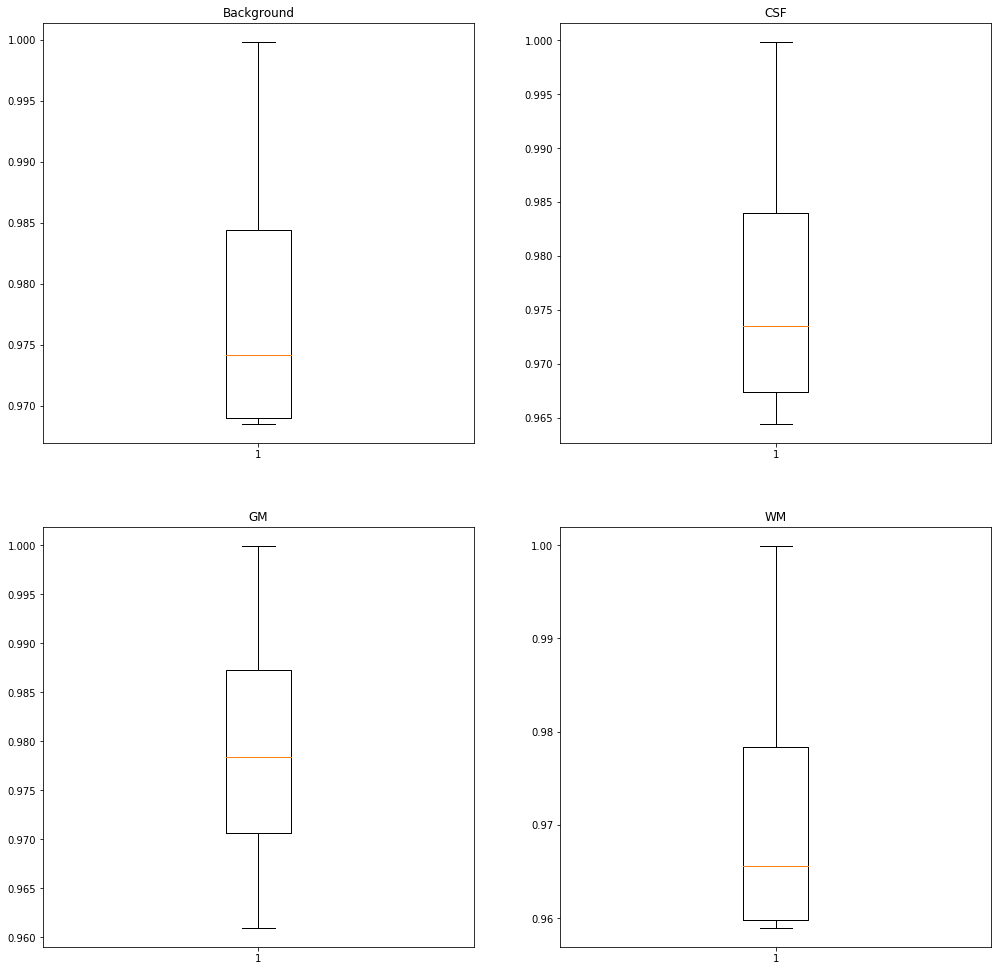

In [21]:
# Summarize the 600 dice score per tissue in box-and-whisker-plots
fig = plt.figure(figsize=(17,17))
plt.subplot(2, 2, 1)
plt.title("Background")
plt.boxplot(all_dice[:][0])
plt.subplot(2, 2, 2)
plt.title("CSF")
plt.boxplot(all_dice[:][1])
plt.subplot(2, 2, 3)
plt.title("GM")
plt.boxplot(all_dice[:][2])
plt.subplot(2, 2, 4)
plt.title("WM")
plt.boxplot(all_dice[:][3])
plt.show()

We observe really good dice score in this box and whisker plot for every segmentation class.

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [22]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + './segs_refs/'

vols = np.zeros((3,meta_data['ID'].count()))
voxel_volume = img_spacing[0]*img_spacing[1]*img_spacing[2] 
#seg_filenames = glob.glob(seg_dir + '*.nii.gz')
#seg_filenames = [f for f in seg_filenames if ID in f]

for i in range(meta_data['ID'].count()):
    img = sitk.ReadImage(seg_dir + meta_data['ID'][i]+'.nii.gz')
    img_array = sitk.GetArrayFromImage(img)
    CSF = np.count_nonzero(img_array == 1)
    GM = np.count_nonzero(img_array == 2)
    WM = np.count_nonzero(img_array == 3)
    vols[0][i] = CSF * voxel_volume
    vols[1][i] = GM * voxel_volume
    vols[2][i] = WM * voxel_volume

Plot features versus age.

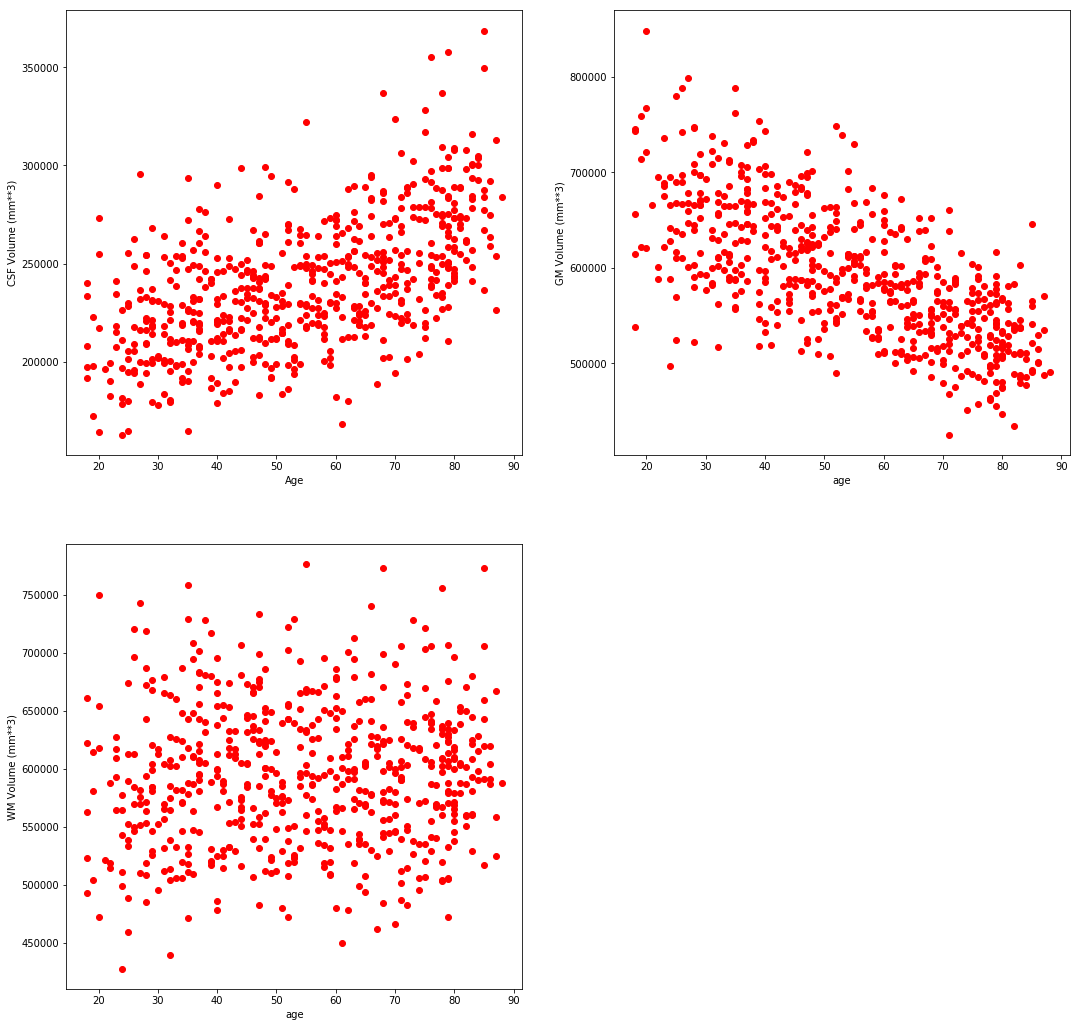

In [23]:
fig = plt.figure(figsize=(18,18))
plt.subplot(2, 2, 1)

plt.scatter(meta_data['age'], vols[0][:], c='r')
plt.xlabel('Age')
plt.ylabel('CSF Volume (mm**3)')

plt.subplot(2, 2, 2)
plt.scatter(meta_data['age'], vols[1][:], c='r')
plt.xlabel('age')
plt.ylabel('GM Volume (mm**3)')

plt.subplot(2, 2, 3)
plt.scatter(meta_data['age'], vols[2][:], c='r')
plt.xlabel('age')
plt.ylabel('WM Volume (mm**3)')

plt.show()


In [24]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,meta_data['ID'].count()))

for i in range(len(vols[0])):
    CSF = vols[0][i]
    GM = vols[1][i]
    WM = vols[2][i]
    total = GM + WM + CSF
    vols_normalised[0][i] = CSF / total
    vols_normalised[1][i] = GM / total
    vols_normalised[2][i] = WM / total

### Age regression and cross-validation



Linear Regression
R2 coefficient: 0.7673892837934357
Mean Absolute Error: 7.1258333333333335


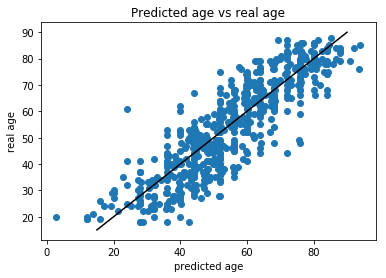

GradientBoosting Regression
R2 coefficient: 0.7417827692724595
Mean Absolute Error: 7.1366001059913335


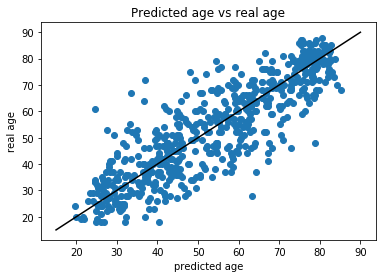

RandomForest Regression
R2 coefficient: 0.7970018489698203
Mean Absolute Error: 6.532917525305609


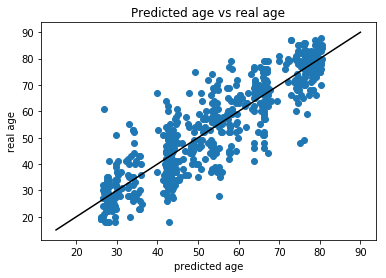

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.utils import shuffle

# Data preprocessing
np.random.seed(0)
X = vols_normalised.T
y = meta_data['age'].values
X, y = shuffle(X, y)
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)
X_fold1 = X[:300]
X_fold2 = X[300:]
y_fold1 = y[:300]
y_fold2 = y[300:]



#regr = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=1000, n_jobs=-1)
#regr = GradientBoostingRegressor(max_depth=5, learning_rate=0.01, n_estimators=1000)

#fold1
regr1 = linear_model.LinearRegression()
regr1.fit(X_fold1, y_fold1)
#fold2
regr2 = linear_model.LinearRegression()
regr2.fit(X_fold2, y_fold2)
#metrics
R2 = (regr1.score(X_fold2, y_fold2) + regr2.score(X_fold1, y_fold1))/2
predictions = np.concatenate((regr2.predict(X_fold1), regr1.predict(X_fold2)), axis=0)
MAE = sum(abs(predictions-y))/len(predictions)
#prints
print("Linear Regression")
print("R2 coefficient:", R2)
print("Mean Absolute Error:", MAE)
plt.scatter(predictions, y)
plt.plot([15,90], [15,90], c='black')
plt.title("Predicted age vs real age")
plt.xlabel('predicted age')
plt.ylabel('real age')
plt.show()

#fold1
regr1 = GradientBoostingRegressor(max_depth=5, learning_rate=0.01, n_estimators=1000)
regr1.fit(X_fold1, y_fold1)
#fold2
regr2 = GradientBoostingRegressor(max_depth=5, learning_rate=0.01, n_estimators=1000)
regr2.fit(X_fold2, y_fold2)
#metrics
R2 = (regr1.score(X_fold2, y_fold2) + regr2.score(X_fold1, y_fold1))/2
predictions = np.concatenate((regr2.predict(X_fold1), regr1.predict(X_fold2)), axis=0)
MAE = sum(abs(predictions-y))/len(predictions)
#prints
print("GradientBoosting Regression")
print("R2 coefficient:", R2)
print("Mean Absolute Error:", MAE)
plt.scatter(predictions, y)
plt.plot([15,90], [15,90], c='black')
plt.title("Predicted age vs real age")
plt.xlabel('predicted age')
plt.ylabel('real age')
plt.show()

#fold1
regr1 = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=1000, n_jobs=-1)
regr1.fit(X_fold1, y_fold1)
#fold2
regr2 = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=1000, n_jobs=-1)
regr2.fit(X_fold2, y_fold2)
#metrics
R2 = (regr1.score(X_fold2, y_fold2) + regr2.score(X_fold1, y_fold1))/2
predictions = np.concatenate((regr2.predict(X_fold1), regr1.predict(X_fold2)), axis=0)
MAE = sum(abs(predictions-y))/len(predictions)
#prints
print("RandomForest Regression")
print("R2 coefficient:", R2)
print("Mean Absolute Error:", MAE)
plt.scatter(predictions, y)
plt.plot([15,90], [15,90], c='black')
plt.title("Predicted age vs real age")
plt.xlabel('predicted age')
plt.ylabel('real age')
plt.show()



### MAE of 6.5 with our predicted segmentation

By comparing a LinearRegressor and a fine-tuned RandomForest and GradientBoosting Regressor we are able to get a MAE of 6.5 with our predicted segmentation.
The plot represent the predicted age vs the real age for each regessor. We can see how RandomForestRegressor is trying to group the prediction, while the LinearRegressor
created a smoother regression.

### PCA and Age regression: Pre-processing



In [26]:
ID = meta_data['ID']


In [27]:
list_filename = []
for i in range(len(greymatter_filenames)):
    list_filename.append([f for f in greymatter_filenames if ID[i] in f][0])


In [28]:
def resample(img, new_size=None, new_spacing=None):
    old_size = img.GetSize()
    old_spacing = img.GetSpacing()
    
    if new_size is None and new_spacing is None:
        return img
    
    if new_size is None:
        # Compute new image dimensions based on the desired rescaling of the voxel spacing
        new_size = [int(np.ceil(old_size[d] * old_spacing[d] / new_spacing[d])) for d in range(3)]

    if new_spacing is None:
        # Compute new voxel spacing based on the desired rescaling of the image dimensions
        new_spacing = [old_spacing[d] * old_size[d] / new_size[d] for d in range(3)]

    # Smooth the input image with anisotropic Gaussian filter
    img_smoothed = img
    for d in range(3):
        # Note how the blurring strength can be different in each direction,
        # if the scaling factors are different.
        factor = new_spacing[d] / old_spacing[d]
        sigma = 0.2 * factor
        img_smoothed = sitk.RecursiveGaussian(img_smoothed, sigma=sigma, direction=d)

    # Finally, apply the resampling operation
    img_resampled = sitk.ResampleImageFilter().Execute(
        img_smoothed,        # Input image
        new_size,            # Output image dimensions
        sitk.Transform(),    # Coordinate transformation. sitk.Transform() is a dummy identity transform,
                             # as we want the brain to be in exactly the same place. When we do image registration,
                             # for example, this can be a linear or nonlinear transformation.
        sitk.sitkLinear,     # Interpolation method (cf. also sitk.sitkNearestNeighbor and many others)
        img.GetOrigin(),     # Output image origin (same)
        new_spacing,         # Output voxel spacing
        img.GetDirection(),  # Output image orientation (same)
        0,                   # Fill value for points outside the input domain
        img.GetPixelID())    # Voxel data type (same)

    return img_resampled

In [29]:
filename_length = len(list_filename)
img_data = []
for i in range(filename_length):
    current_img = sitk.ReadImage(list_filename[i])
    img_diffusion = sitk.GradientAnisotropicDiffusion(current_img)
    #resampling does not offers better performance
    #img_resampled = resample(img_diffusion, new_spacing=[2.5,2.5,2.5])
    img_array = sitk.GetArrayFromImage(img_diffusion)
    img_array = img_array.reshape(-1)
    img_data.append(img_array)

########################################

In [30]:
img_data = np.array(img_data)

In [31]:
X = img_data #PRE-PROCESSED IMAGE DATA
y = meta_data['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(600, 874800)
(600, 1)


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [32]:
idx = np.random.permutation(len(X))
X,y = X[idx], y[idx]

X_fold1 = X[:300]
X_fold2 = X[300:]
y_fold1 = y[:300]
y_fold2 = y[300:]

Linear Regression
Mean Absolute Error: [5.61117082]


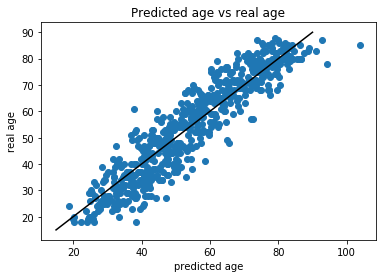

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.decomposition import PCA

age_prediction = []

pca1 = PCA(n_components=0.95)
pca1.fit(X_fold2)

pca2 = PCA(n_components=0.95)
pca2.fit(X_fold1)

X_fold1_pca1 = pca1.transform(X_fold1)
X_fold2_pca1 = pca1.transform(X_fold2)


regr1 = linear_model.LinearRegression()
regr1.fit(X_fold2_pca1, y_fold2)
pred1 = regr1.predict(X_fold1_pca1)

X_fold1_pca2 = pca2.transform(X_fold1)
X_fold2_pca2 = pca2.transform(X_fold2)

regr2 = linear_model.LinearRegression()
regr2.fit(X_fold1_pca2, y_fold1)
pred2 = regr2.predict(X_fold2_pca2)

predictions = np.concatenate((pred1, pred2), axis=0)
MAE = sum(abs(predictions-y))/len(predictions)
#prints
print("Linear Regression")
print("Mean Absolute Error:", MAE)
plt.scatter(predictions, y)
plt.plot([15,90], [15,90], c='black')
plt.title("Predicted age vs real age")
plt.xlabel('predicted age')
plt.ylabel('real age')
plt.show()




c:\users\theoc\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\theoc\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest
Mean Absolute Error: 7.258100000000001


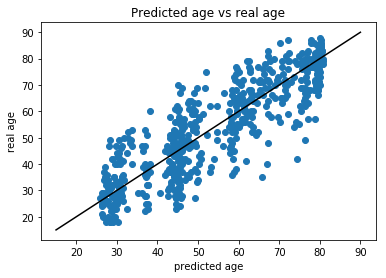

In [36]:
#fold1
regr1 = RandomForestRegressor(max_depth=None, n_estimators=200, n_jobs=-1)
regr1.fit(X_fold2_pca1, y_fold2)
pred1 = regr1.predict(X_fold1_pca1)

#fold2
regr2 = RandomForestRegressor(max_depth=None, n_estimators=200, n_jobs=-1)
regr2.fit(X_fold1_pca2, y_fold1)
pred2 = regr2.predict(X_fold2_pca2)

predictions = np.concatenate((pred1, pred2), axis=0)
MAE = np.sum(abs(predictions-y.reshape(600,)))/len(predictions)
#prints
print("Random Forest")
print("Mean Absolute Error:", MAE)
plt.scatter(predictions, y)
plt.plot([15,90], [15,90], c='black')
plt.title("Predicted age vs real age")
plt.xlabel('predicted age')
plt.ylabel('real age')
plt.show()
